In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline  
from torchinfo import summary

In [2]:
DOWNLOAD_CIFAR = True  

In [3]:
batch_size = 16

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# image = (image - mean) / std
# minimum value 0 will be converted to (0-0.5)/0.5=-1, 
# maximum value of 1 will be converted to (1-0.5)/0.5=1

cifar_train_data = torchvision.datasets.CIFAR10(
    root='./cifar', 
    train=True,
    download=DOWNLOAD_CIFAR, 
    transform=transform)

cifar_train_loader = torch.utils.data.DataLoader(
    cifar_train_data, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2)

cifar_test_data = torchvision.datasets.CIFAR10(
    root='./cifar', 
    train=False,
    download=DOWNLOAD_CIFAR, 
    transform=transform)

cifar_test_loader = torch.utils.data.DataLoader(
    cifar_test_data, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
     

100.0%


Extracting ./cifar\cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


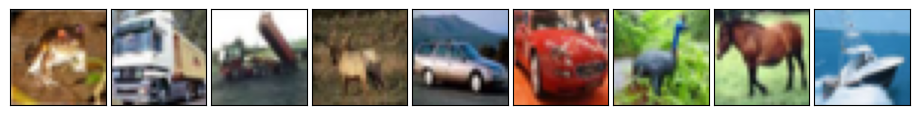

In [4]:
# plot example
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(cifar_train_data.data[i], cmap='gray')

In [5]:
cifar_train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
class CifarNet(nn.Module):
    def __init__(self):
        """CifarNet Builder."""
        super(CifarNet, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=None, padding=0),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(16384,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512,10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
cifarnet = CifarNet().to(device)

In [10]:
import torch.optim as optim
cifar_loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifarnet.parameters(), lr=0.001)

In [11]:
EPOCH = 2
for epoch in range(EPOCH):

    running_loss = 0.0
    for step, (x, y) in enumerate(cifar_train_loader, 0):
        x = x.cuda()
        y = y.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cifarnet(x)
        loss = cifar_loss_func(outputs, y)
        loss.backward()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (step+1) % 1000 == 0: 
            print('step:{}'.format(step), '| loss:{:.4f}'.format(running_loss/300) )   
            running_loss = 0.0

print('Finished Training ...')

step:999 | loss:7.4695
step:1999 | loss:6.7361
step:2999 | loss:6.1345
step:999 | loss:5.6973
step:1999 | loss:5.4211
step:2999 | loss:5.2294
Finished Training ...


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for x, y in cifar_test_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = cifarnet(x)

        predicted = torch.max(outputs.data, 1)[1]
        total += y.size(0)
        correct += (predicted == y).sum().item()

print('Accuracy of the network : %d %%' % (100 * correct / total))

Accuracy of the network : 46 %
